In [70]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [71]:
# !pip install pyarrow==0.10.0

In [144]:
data = pd.read_parquet('data.parquet')
data['clicked_email'] = data['first_click_time_utc'].isnull()==False

In [145]:
data.shape

(100966, 15)

In [146]:
data.columns

Index(['user_uuid', 'gender', 'age_yrs', 'acs_median_income', 'adi_natrank',
       'avg_years_educ', 'pct_unempl_comp', 'pop_density', 'prob_has_diabetes',
       'high_socio_economic_status', 'email_name', 'sent_time_utc',
       'first_open_time_utc', 'first_click_time_utc', 'clicked_email'],
      dtype='object')

In [147]:
dtypes = defaultdict(list)
for i in data.columns:
    dtypes[str(data[i].dtype)].append(i)
for i in dtypes:
    print(i, ':' , dtypes[i], '\n')

object : ['user_uuid', 'gender', 'email_name'] 

float64 : ['age_yrs', 'acs_median_income', 'adi_natrank', 'avg_years_educ', 'pct_unempl_comp', 'pop_density', 'prob_has_diabetes'] 

int64 : ['high_socio_economic_status'] 

datetime64[ns] : ['sent_time_utc', 'first_open_time_utc', 'first_click_time_utc'] 

bool : ['clicked_email'] 



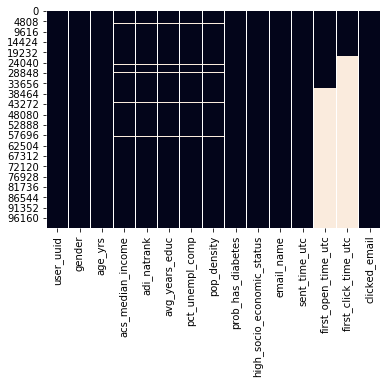

In [148]:
sns.heatmap(data.isnull(), cbar=False)

# Categorical Variables

In [149]:
data.user_uuid.nunique()

100964

In [150]:
data.gender.value_counts()

Male       52385
Female     48579
Unknown        2
Name: gender, dtype: int64

In [151]:
data.email_name.value_counts()

TESTIMONIAL         25081
WHATYOUGET          24943
PROGRAMOVERVIEW     24531
6FEATUREOVERVIEW    24137
TEXTONLY             2274
Name: email_name, dtype: int64

In [152]:
one_hot_gender = pd.get_dummies(data['gender'], prefix='gender')
gender_fts = list(one_hot_gender.columns)
data = data.join(one_hot_gender)

In [153]:
one_hot_email = pd.get_dummies(data['email_name'], prefix='email')
email_fts = list(one_hot_email.columns)
data = data.join(one_hot_email)

In [154]:
for i in email_fts:
    print(i, np.corrcoef(data[i], data['clicked_email'])[0][1])

email_6FEATUREOVERVIEW 0.019227310583341935
email_PROGRAMOVERVIEW -0.0011364964117144603
email_TESTIMONIAL -0.0415442238582263
email_TEXTONLY 0.0025992409516959487
email_WHATYOUGET 0.022842973345436227


# Continuous Variables

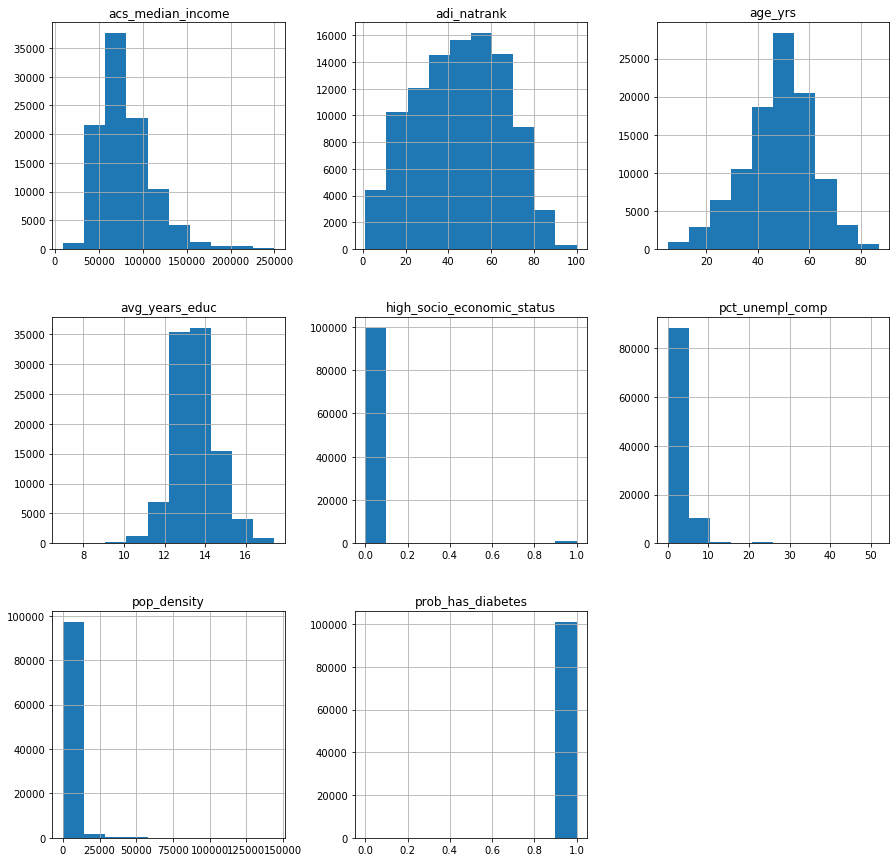

In [155]:
_ = data[dtypes['float64']+dtypes['int64']].hist(figsize=(15,15))

In [156]:
data['prob_has_diabetes'].value_counts()

1.0    100965
0.0         1
Name: prob_has_diabetes, dtype: int64

In [157]:
# sns.pairplot(data.sample(frac=0.1), 
#              hue='clicked_email', 
# #              kind='hist',
#              vars=dtypes['float64'],
#              dropna=True
#             )

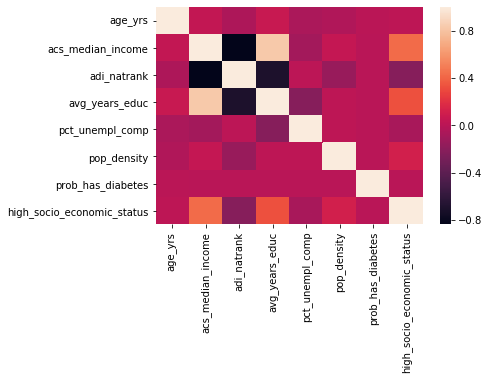

In [158]:
sns.heatmap(data[dtypes['float64']+dtypes['int64']].corr())

In [159]:
data[['avg_years_educ','acs_median_income', 'high_socio_economic_status']].dropna().corr()

,avg_years_educ,acs_median_income,high_socio_economic_status
avg_years_educ,1.000000,0.829053,0.329915
acs_median_income,0.829053,1.000000,0.433510
high_socio_economic_status,0.329915,0.433510,1.000000


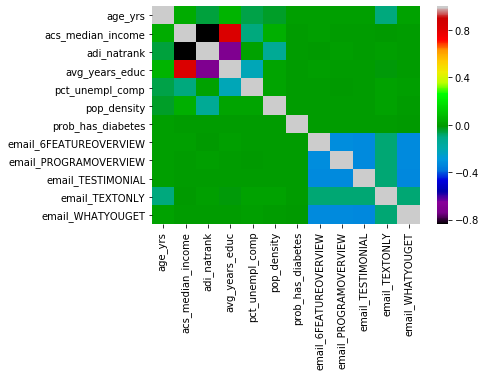

In [161]:
sns.heatmap(data[dtypes['float64'] + email_fts].corr(), cmap='nipy_spectral')

data Not Missing at Random

In [162]:
data[dtypes['float64']].isnull().sum()

age_yrs                0
acs_median_income    963
adi_natrank          963
avg_years_educ       963
pct_unempl_comp      963
pop_density          963
prob_has_diabetes      0
dtype: int64

In [163]:
data[dtypes['float64']].isnull().sum(axis=1).unique()

array([0, 5])

In [164]:
#doesnt matter for decision tree type classifier
# data[dtypes['float64']] = data[dtypes['float64']].fillna(-1)

# Target Variables

In [165]:
data['first_click_time_utc'].isnull().value_counts()

True     80000
False    20966
Name: first_click_time_utc, dtype: int64

In [166]:
data['first_open_time_utc'].isnull().value_counts()

True     65017
False    35949
Name: first_open_time_utc, dtype: int64

In [167]:
who_didnt_open = data[data['first_open_time_utc'].isnull()==True]
who_didnt_open[who_didnt_open['first_click_time_utc'].isnull()==False]

,user_uuid,gender,age_yrs,acs_median_income,adi_natrank,avg_years_educ,pct_unempl_comp,pop_density,prob_has_diabetes,high_socio_economic_status,...,first_click_time_utc,clicked_email,gender_Female,gender_Male,gender_Unknown,email_6FEATUREOVERVIEW,email_PROGRAMOVERVIEW,email_TESTIMONIAL,email_TEXTONLY,email_WHATYOUGET
20965,c9730317-9b7b-4617-8e09-8189993fc6cf,Male,65.0,174419.0,14.254545,16.355422,1.299264,17198.03802,1.0,1,...,2021-01-04 18:33:26.189,True,0,1,0,1,0,0,0,0


In [168]:
data['clicked_email'] = data['first_click_time_utc'].isnull()==False

# Modeling

In [325]:
pred_cols = gender_fts+ \
            email_fts+ \
            dtypes['float64'] + \
            dtypes['int64']
pred_cols.remove('gender_Unknown')
pred_cols.remove('prob_has_diabetes')
pred_cols.remove('avg_years_educ')

In [326]:
data[pred_cols].isnull().sum()

gender_Female                   0
gender_Male                     0
email_6FEATUREOVERVIEW          0
email_PROGRAMOVERVIEW           0
email_TESTIMONIAL               0
email_TEXTONLY                  0
email_WHATYOUGET                0
age_yrs                         0
acs_median_income             963
adi_natrank                   963
pct_unempl_comp               963
pop_density                   963
high_socio_economic_status      0
dtype: int64

In [344]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression

In [328]:
training_data = data[data[pred_cols].isnull().sum(axis=1)==0]

In [329]:
training_data.shape

(100003, 23)

In [330]:
X_train, X_test, y_train, y_test = train_test_split(training_data[pred_cols], training_data['clicked_email'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=training_data['clicked_email'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80002, 13), (20001, 13), (80002,), (20001,))

In [331]:
mod = RandomForestClassifier().fit(X_train, y_train)

In [332]:
y_pred = mod.predict(X_test)

In [333]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.80      0.95      0.87     15855
       True       0.25      0.06      0.10      4146

avg / total       0.68      0.77      0.71     20001



In [334]:
print(roc_auc_score(y_test, mod.predict_proba(X_test)[:,1]))

0.5359515876134463


# Feature Selection

In [335]:
listt = []
ranking = SelectKBest(chi2, k=5).fit(X_train, y_train)
for i, (score, feature) in enumerate(zip(ranking.scores_, X_train.columns)):
    listt.append((score, feature))

kb_df = pd.DataFrame(listt, columns=['score', 'feature'])
kb_df.sort_values(by=['score'], ascending=False)

,score,feature
11,65007.617386,pop_density
8,15426.404679,acs_median_income
4,106.025656,email_TESTIMONIAL
6,26.182067,email_WHATYOUGET
2,24.060713,email_6FEATUREOVERVIEW
0,23.394557,gender_Female
1,21.843669,gender_Male
10,15.930710,pct_unempl_comp
7,11.054623,age_yrs
12,4.905399,high_socio_economic_status


In [336]:
pred_cols.remove('adi_natrank')
pred_cols.remove('email_TEXTONLY')
pred_cols.remove('email_PROGRAMOVERVIEW')

In [337]:
X_train, X_test, y_train, y_test = train_test_split(training_data[pred_cols], training_data['clicked_email'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=training_data['clicked_email'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80002, 10), (20001, 10), (80002,), (20001,))

In [338]:
mod = RandomForestClassifier().fit(X_train, y_train)

In [339]:
y_pred = mod.predict(X_test)

In [340]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.80      0.95      0.87     15855
       True       0.28      0.07      0.11      4146

avg / total       0.69      0.77      0.71     20001



In [341]:
print(roc_auc_score(y_test, y_pred))

0.5106926419373109


In [342]:
roc_auc_score(y_test, mod.predict_proba(X_test)[:,1])

0.5349308882368753

# Chose Optimal Threshold

In [353]:
X_train, X_test, y_train, y_test = train_test_split(training_data[pred_cols], training_data['clicked_email'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=training_data['clicked_email'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y_train)
X_train.shape, X_test.shape, X_val.shape, y_val.shape, y_train.shape, y_test.shape

((64001, 10), (20001, 10), (16001, 10), (16001,), (64001,), (20001,))

In [360]:
mod = RandomForestClassifier().fit(X_train, y_train)
mod.fit(X_train, y_train)
y_proba = model.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_proba)

In [361]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.216579, G-Mean=0.508


In [362]:
y_pred = mod.predict_proba(X_test)[:,1]>thresholds[ix]

In [363]:
print(roc_auc_score(y_test, y_pred))

0.5238299011346039
